In [2]:
%matplotlib inline

import astropy.constants as const
import astropy.units as u
from astropy.visualization import quantity_support, time_support
# These commands allow us to plot astropy Quantities and Times
quantity_support()
time_support()

import matplotlib.pyplot as plt

import sunpy.map
from sunpy.net import Fido
from sunpy.net import attrs as a
from sunpy.time import parse_time

from heliopy.data import omni

# 1. Search for data

In [28]:
t = parse_time('2019-12-22 02:00:00')
dt = 10 * u.minute
result = Fido.search(a.Time(t, t + dt),
                     a.Instrument('AIA'),
                     a.Wavelength(193 * u.Angstrom))
result

Start Time [1],End Time [1],Source,Instrument,Type,Wavelength [2]
,,,,,Angstrom
str19,str19,str3,str3,str8,float64
2019-12-22 02:00:04,2019-12-22 02:00:05,SDO,AIA,FULLDISK,193.0 .. 193.0
2019-12-22 02:00:16,2019-12-22 02:00:17,SDO,AIA,FULLDISK,193.0 .. 193.0
2019-12-22 02:00:28,2019-12-22 02:00:29,SDO,AIA,FULLDISK,193.0 .. 193.0
2019-12-22 02:00:40,2019-12-22 02:00:41,SDO,AIA,FULLDISK,193.0 .. 193.0
2019-12-22 02:00:52,2019-12-22 02:00:53,SDO,AIA,FULLDISK,193.0 .. 193.0
2019-12-22 02:01:04,2019-12-22 02:01:05,SDO,AIA,FULLDISK,193.0 .. 193.0
2019-12-22 02:01:16,2019-12-22 02:01:17,SDO,AIA,FULLDISK,193.0 .. 193.0
2019-12-22 02:01:28,2019-12-22 02:01:29,SDO,AIA,FULLDISK,193.0 .. 193.0


# 2. Download data

In [30]:
local_files = Fido.fetch(result[0, 0])
local_files

Files Downloaded:   0%|          | 0/1 [00:00<?, ?file/s]

aia_lev1_193a_2019_12_22t02_00_04_84z_image_lev1.fits:   0%|          | 0.00/10.6M [00:00<?, ?B/s]

['/Users/dstansby/sunpy/data/aia_lev1_193a_2019_12_22t02_00_04_84z_image_lev1.fits']

# 3. Load and plot data

/Users/dstansby/miniconda3/envs/solarnet/lib/python3.8/site-packages/astropy/visualization/wcsaxes/core.py:211: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  return super().imshow(X, *args, origin=origin, **kwargs)


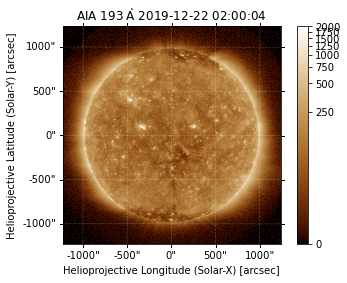

In [32]:
aia_map = sunpy.map.Map(local_files[0])
aia_map.peek(vmin=0, vmax=2000)

# 4. Load in-situ data

In [34]:
omni_data = omni.h0_mrg1hr(aia_map.date.datetime,
                           (aia_map.date + (10 * u.day)).datetime)
# Remove any gaps in the velocity data - this is important for later steps
omni_data._data = omni_data.to_dataframe().dropna(subset=['V'])

# 5. Backmap data

In [36]:
def backmapped_time(t_earth, vsw):
    t_earth = parse_time(t_earth)
    r_earth = 1 * const.au
    r_sun = const.R_sun
    return t_earth - (r_earth - r_sun) / vsw

In [37]:
t_sun = backmapped_time(omni_data.index, omni_data.quantity('V'))

# 6. Plot results

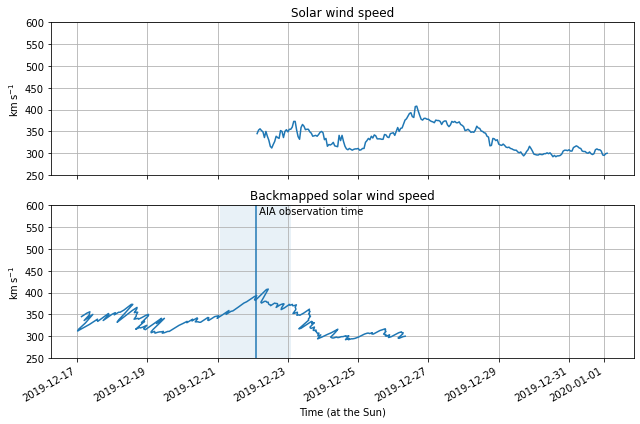

In [44]:
fig, axs = plt.subplots(nrows=2, sharex=True, figsize=(9, 6), tight_layout=True)
ax = axs[0]
ax.plot(omni_data.index, omni_data.quantity('V'))
ax.set_title('Solar wind speed')
ax.set_xlabel('Time (at Earth)')
ax.grid()
ax.set_ylim(250, 600)

ax = axs[1]
ax.plot(t_sun.datetime, omni_data.quantity('V'))
ax.set_title('Solar wind speed')
ax.set_xlabel('Time (at the Sun)')
ax.grid()
ax.set_title('Backmapped solar wind speed')

ax.axvline(aia_map.date.datetime)
ax.set_ylim(250, 600)
ax.text(aia_map.date.datetime, 580, ' AIA observation time')
ax.axvspan((aia_map.date - 1 * u.day).datetime,
           (aia_map.date + 1 * u.day).datetime,
           alpha=0.1)

fig.align_ylabels()
fig.autofmt_xdate()